In [2]:
!pip install torch torchvision torchaudio
!pip install pandas scikit-learn matplotlib seaborn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/InfosysSB/Preprocessed_Dataset/FakeNewsNet_Preprocessed.csv')

In [7]:
# Show the first few rows of the dataset
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation on real...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,people choice award 2018 the best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma spark rumour of inappr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl 10 year later upper east siders sh...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


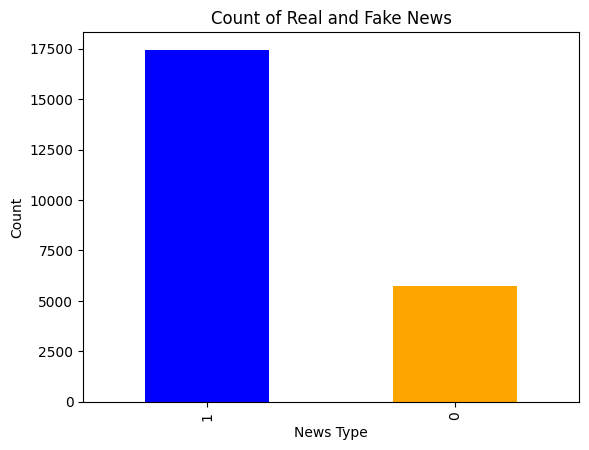

In [8]:
# Show the count of real and fake news
df['real'].value_counts().plot(kind='bar', color=['blue', 'orange'], title='Count of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()


In [9]:
# Prepare the data
X = df['title'].values
y = df['real'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


In [10]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return {
            'text': torch.tensor(text, dtype=torch.float32).unsqueeze(0),  # Add a dimension to match LSTM input
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = FakeNewsDataset(X_train_tfidf, y_train)
val_dataset = FakeNewsDataset(X_val_tfidf, y_val)
test_dataset = FakeNewsDataset(X_test_tfidf, y_test)


In [11]:
# Define the input and output dimensions
input_dim = X_train_tfidf.shape[1]
output_dim = 2

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=False, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        x = self.dropout(x)
        return self.softmax(out)

In [12]:
# Define the hyperparameters grid
param_grid = {
    'hidden_dim': [64, 128],
    'num_layers': [1, 2],
    'bidirectional': [False, True],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32]
}


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            texts = batch['text'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * texts.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
                labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
                outputs = model(texts)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * texts.size(0)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_loss.append(epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

    return train_loss, val_loss


In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            texts = batch['text'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [15]:
best_accuracy = 0
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    model = LSTMClassifier(input_dim, params['hidden_dim'], output_dim, params['num_layers'], params['bidirectional'])
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=0.001)

    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

    y_val_true, y_val_pred = evaluate_model(model, val_loader)
    accuracy = accuracy_score(y_val_true, y_val_pred)

    print(f"Validation Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")



Training with params: {'batch_size': 16, 'bidirectional': False, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 1}
Epoch 1/5, Train Loss: 0.48637002900926596, Validation Loss: 0.41775724577224904
Epoch 2/5, Train Loss: 0.37676507649254276, Validation Loss: 0.39697176650025084
Epoch 3/5, Train Loss: 0.3448447365741712, Validation Loss: 0.3832938100779437
Epoch 4/5, Train Loss: 0.32790809281521444, Validation Loss: 0.3824528617731346
Epoch 5/5, Train Loss: 0.31565686130215287, Validation Loss: 0.38174737294343547
Validation Accuracy: 0.8382226056945643
Training with params: {'batch_size': 16, 'bidirectional': False, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2}
Epoch 1/5, Train Loss: 0.48230030184751077, Validation Loss: 0.39983022007271585
Epoch 2/5, Train Loss: 0.36404773013790753, Validation Loss: 0.38683862949466785
Epoch 3/5, Train Loss: 0.3245455623480735, Validation Loss: 0.38583556038742955
Epoch 4/5, Train Loss: 0.2976805169563276, Validation Loss: 0.386210

In [17]:
# Train the best model on full training data and evaluate on test data
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = LSTMClassifier(input_dim, best_params['hidden_dim'], output_dim, best_params['num_layers'], best_params['bidirectional'])
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

y_test_true, y_test_pred = evaluate_model(model, test_loader)

accuracy = accuracy_score(y_test_true, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred, average='binary')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-score: {f1}")


Epoch 1/5, Train Loss: 0.4444344611985888, Validation Loss: 0.38492311227414194
Epoch 2/5, Train Loss: 0.3054552738744367, Validation Loss: 0.3953242240742016
Epoch 3/5, Train Loss: 0.26219687786769014, Validation Loss: 0.4327212755694484
Epoch 4/5, Train Loss: 0.23694625816640394, Validation Loss: 0.46608456480698507
Epoch 5/5, Train Loss: 0.217929427439079, Validation Loss: 0.5033096411394805
Test Accuracy: 0.8237068965517241
Test Precision: 0.8633864760857614
Test Recall: 0.9072790294627383
Test F1-score: 0.8847887323943662


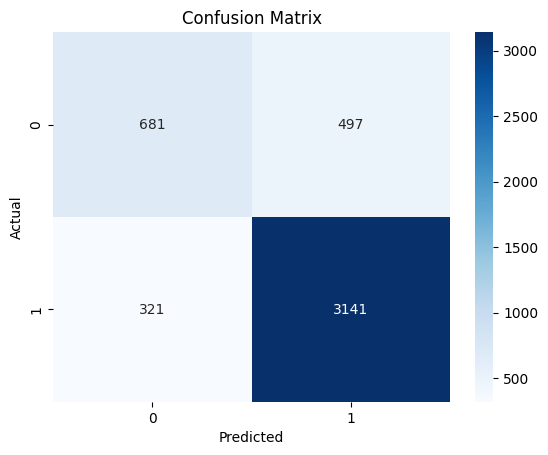

In [19]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Predict custom input
def predict_custom_input(model, input_text, vectorizer):
    model.eval()
    input_tfidf = vectorizer.transform([input_text]).toarray()
    input_tensor = torch.tensor(input_tfidf, dtype=torch.float32).unsqueeze(0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()
    return "Real" if prediction == 1 else "Fake"

custom_input = "broward county sheriff fired for lying parkland"
print("Prediction for custom input:", predict_custom_input(model, custom_input, vectorizer))


Prediction for custom input: Fake
